# SARIMA(p,d,q)(P,D,Q,s)
# Seasonal Autoregressive Integrated Moving Averages

Vmoas a aplicar ARIMA a datos de contaminacion
Y tambien haremos prediccion


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Herramientas
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # ETS Plots
                            

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset
df = pd.read_csv('co2_mm_mlo.csv')

# promedio mensial de niveles de CO2 en Hawaii a nivel mensial

In [2]:
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [3]:
# Añadir una variable "date"
# vamoa a hacerlo a mano ...usando un diccionario... asumimos el primer dia del mes (evitar el ultimo dia)

df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

In [4]:
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [5]:
# Hacer que la variable "date" sea el indice con frecuencia mensual

df.set_index('date',inplace=True) # no crea un objeto nuevo ... lo añade
df.index.freq = 'MS'
df.head()

# la variable interpolated contiene los valores faltantes habiendo interpolado los intermedios

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


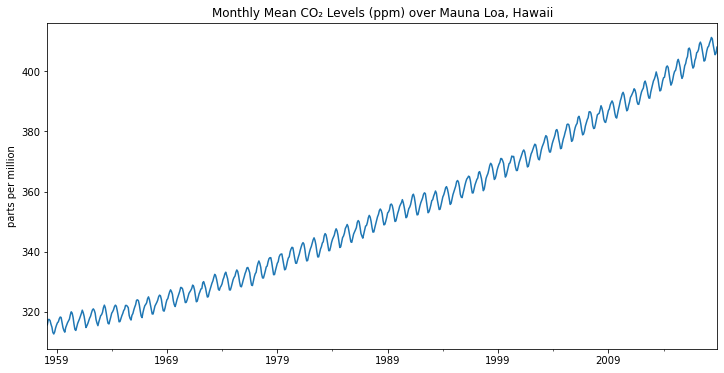

In [6]:
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel='' 

ax = df['interpolated'].plot(figsize=(12,6),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Hay una clara estacionalidad y una tendencia al alza
# para ver la estacionalidad podemos hacer la descomposicion 

### Descomposición en 3 factores

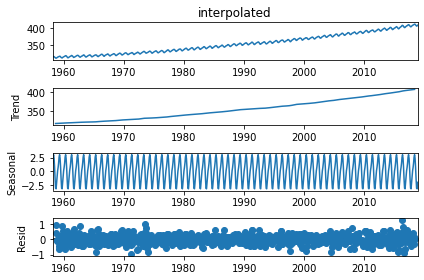

In [7]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

Aunque sea pequeña en comparación con la escala de los datos, hay una estacionalidad anual.
Tanto aditivio como multiplicativo da un comoponente estacional ---> vamos a usar SARIMA

### Dividir en datos de entrenamiento y prueba

In [8]:
len(df)

# ponemos un año de prueba ...

729

In [9]:
# Prueba
train = df.iloc[:717]
test = df.iloc[717:]

# Modelo SARIMA(1,1,1)(1,0,1,12) 

Elegimos uno para empezar para hacer un estudio estacional. Usamos la variable interpolated menos los ultimos 12 meses.

Se ve que no es estacionario asi un d=1
La parte estacional ponemos un ciclo de 12 meses para que se repita año a año

es un SARIMA ( no tiene X, exogenas)

In [11]:
model = SARIMAX(train['interpolated'],order=(1,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

# todos los coeficientes son significativos
# suponemos que es el mejor model


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -202.970
Date:                            Wed, 11 May 2022   AIC                            415.941
Time:                                    22:16:00   BIC                            438.809
Sample:                                03-01-1958   HQIC                           424.772
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2333      0.073      3.204      0.001       0.091       0.376
ma.L1         -0.5796      0.066     -8.768      0.000      -0.709      -0.450
ar.S.L12       0.9996      0.000   2870.985      0.000       0.999       1.000
ma.S.L12      -0.8629      0.023    -37.540      0.000      -0.908      -0.818
sigma2         0.0956      0.005     20.612      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                 4.90
Prob(Q):                              0.60   Prob(JB):                         0.09
Heteroskedasticity (H):               1.13   Skew:                             0.02
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
model = SARIMAX(train['interpolated'],order=(0,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.158
Date:                            Wed, 11 May 2022   AIC                            418.315
Time:                                    22:16:04   BIC                            436.610
Sample:                                03-01-1958   HQIC                           425.380
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3688      0.031    -11.898      0.000      -0.430      -0.308
ar.S.L12       0.9996      0.000   3073.672      0.000       0.999       1.000
ma.S.L12      -0.8641      0.023    -37.523      0.000      -0.909      -0.819
sigma2         0.0961      0.005     20.202      0.000       0.087       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 3.71
Prob(Q):                              0.74   Prob(JB):                         0.16
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
model = SARIMAX(train['interpolated'],order=(2,1,2),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -203.226
Date:                              Wed, 11 May 2022   AIC                            420.452
Time:                                      22:17:01   BIC                            452.467
Sample:                                  03-01-1958   HQIC                           432.815
                                       - 11-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6803      0.152     -4.465      0.000      -0.979      -0.382
ar.L2          0.2596      0.089      2.922      0.003       0.085       0.434
ma.L1          0.3402      0.144      2.358      0.018       0.057       0.623
ma.L2         -0.5938      0.107     -5.532      0.000      -0.804      -0.383
ar.S.L12       0.9997      0.000   3557.846      0.000       0.999       1.000
ma.S.L12      -0.8782      0.022    -40.673      0.000      -0.921      -0.836
sigma2         0.0963      0.005     19.816      0.000       0.087       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 5.67
Prob(Q):                              0.59   Prob(JB):                         0.06
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
# Obtain predicted values
#obtenemos predicciones - empieza donde acaba el conjunto de entrenamiento y acaba donde acabe el test
# usamos la funcion predict con punto de inicio y final

start=len(train)
end=len(train)+len(test)-1
#predictions = results.predict(start=start, end=end).rename('SARIMA(1,1,1)(1,0,1,12) Predictions')

predictions = results.predict(start=start, end=end)

In [40]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]}, expected={test['interpolated'][i]}")

predicted=406.60218750880495, expected=406.81
predicted=407.8182295114826, expected=407.96
predicted=408.5657006929745, expected=408.32
predicted=409.4719136402745, expected=409.41
predicted=411.0343824046978, expected=410.24
predicted=411.63836072888165, expected=411.24
predicted=410.85541350061203, expected=410.79
predicted=409.162605619217, expected=408.71
predicted=407.0619304706793, expected=406.99
predicted=405.6122284884088, expected=405.51
predicted=405.88543639977013, expected=406.0
predicted=407.4216571445103, expected=408.02


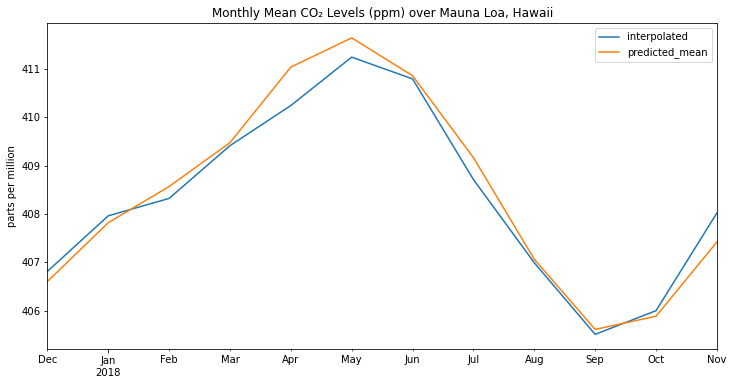

In [37]:
# Plot predictions against known values
title ='Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

### Reentrenar el modelo con todos los datos y predecir el futuro

No es estrictamente necesario pero en series temporales añaden mas informacion ...

In [43]:
model = SARIMAX(df['interpolated'],order=(1,1,1),seasonal_order=(1,0,1,12))
results = model.fit()
fcast = results.predict(len(df),len(df)+36).rename('SARIMA(1,1,1)(1,0,1,12) Forecast')

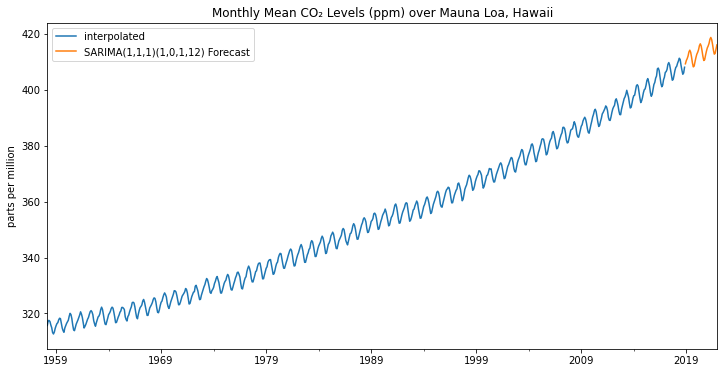

In [44]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.set(xlabel=xlabel, ylabel=ylabel);